In [5]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from pylab import mpl
from sklearn.linear_model import LinearRegression

## read_data

In [6]:
adj_open = pd.read_pickle('D:/redata/fields_full/adj_open.pk')
adj_close = pd.read_pickle('D:/redata/fields_full/adj_close.pk')
Open = pd.read_pickle('D:/redata/fields_full/open.pk')
Close = pd.read_pickle('D:/redata/fields_full/close.pk')

##正常交易非st，halt的票打1.其他为np.nan
st_status = pd.read_pickle('D:/redata/fields_full/st_status.pk')
halt_status = pd.read_pickle('D:/redata/fields_full/halt_status.pk')
st_status = st_status.replace(True,np.nan).replace(False,True)
halt_status = halt_status.replace(True,np.nan).replace(False,True)

adj_return =  adj_close/adj_close.shift(1) - 1
adj_return = adj_return.replace(np.inf,np.nan).replace(-np.inf,np.nan)

##csi500 idx
idx = pd.read_pickle('D:/redata/idx/000905.XSHG_hist_index.pkl').set_index('date')
idx_500_ret = (idx['close']/idx['close'].shift(1) - 1)

C:\Users\sensen.t\AppData\Local\Temp\ipykernel_6452\1410944748.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  st_status = st_status.replace(True,np.nan).replace(False,True)
C:\Users\sensen.t\AppData\Local\Temp\ipykernel_6452\1410944748.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  halt_status = halt_status.replace(True,np.nan).replace(False,True)


In [7]:
##调仓周期
o1o2 = adj_open.shift(-2)/adj_open.shift(-1) - 1 #1日调仓
# o1o2 = adj_open.shift(-5) / adj_open.shift(-1) - 1 #5日调仓
# o1o2 = adj_open.shift(-10) / adj_open.shift(-1) - 1 #10日调仓
# o1o2 = adj_open.shift(-20) / adj_open.shift(-1) - 1 #20日调仓


ret_rank = o1o2.rank(axis=1,ascending=True)

## data_process

In [8]:
##剔除新股，st，halt，补全交易日  ###hist
def compute_condition(new_stk = 20):
    #上市不满60天的label
    drop_new_stk = adj_open.rolling(window=new_stk,min_periods=new_stk).mean()
    #drop_new_stk = drop_new_stk.dropna(how='all'，axis=1)
    drop_new_stk = ~np.isnan(drop_new_stk)  ##TorF
    df = st_status * halt_status * drop_new_stk
    df = df.replace(True,1).replace(False,np.nan)
    return df.loc['2017':]

In [9]:
##行业中性 2023.8.3 更新
def neturalize_ind(factor,risk,risk_cols):
    XY = pd.merge(risk, factor, on=['date', 'ticker'], how='right')
    #print(XY.head(3))
    XY = XY.dropna()
    tradeday = XY.date.unique()
    daily_resid = []
    for date in tqdm(tradeday[:]):
        xy = XY[XY['date'] == date]
        #只保留有因子值的数据
        xy = xy.dropna()

        #数据标准化
        xy[risk_cols] = (xy[risk_cols] - xy[risk_cols].mean())/xy[risk_cols].std()                
        xy['factor'] = (xy['factor']-xy['factor'].mean())/xy['factor'].std() 

        #选出x y
        x = xy.iloc[:,2:-1]
        y = xy['factor']
        #回归
        multi_linear = LinearRegression(fit_intercept=False)  #无截距项
        multi_linear.fit(x, y)
        beta = multi_linear.coef_
        
        #取残差
        xy['beta'] = np.dot(x, beta)
        xy['resid'] = xy['factor'] - xy['beta']
        daily_resid.append(xy)
    data = pd.concat(daily_resid)
    factor = data[['date', 'ticker', 'factor', 'resid']]
    return factor

In [10]:
def factor_neutralize(df,factor_type,if_rank=True,risk=None,risk_cols=None): #factor_type=hist原值；ind行业及其他中性；单个风险因子文件名； if_rank：中性化之前时候对因子做rank处理
    #中性之前是否对因子做rank处理
    if if_rank == True:
        df = df.rank(axis=1, ascending=True)  # 原值越大rank值越大   
    #因子原值
    if factor_type == 'hist':
        factor_rank = df.copy()
    #行业市值中性
    elif factor_type == 'ind':  ###行业和风格中性
        def neu_process(df):
            df = df.stack().reset_index()
            df.columns = ['date','ticker','factor']
            df = neturalize_ind(df,risk,risk_cols)
            resid = df.set_index(['date','ticker'])['resid'].unstack()
            return resid        
        factor_rank = neu_process(df)
        factor_rank = factor_rank.rank(axis=1,ascending=True) 
        
    return factor_rank

In [11]:
def select_num_stocks(n):
    select_stocks = (factor_rank <= n)
    select_stocks_last = select_stocks.iloc[-1:,]
    select_stocks_last = select_stocks_last.replace(True,1).replace(False,np.nan)
    select_stocks_last = select_stocks_last.dropna(how='all',axis=1)
    return select_stocks_last

In [12]:
##因子中性化 需要的数据
risk1 = pd.read_pickle('D:/redata/risk_factor/logcmv.pk')
risk2 = pd.read_pickle('D:/redata/risk_factor/retsum120.pk')
ind = pd.read_pickle('D:/redata/risk_factor/ind_label.pk')#('/Z2_6000/data/ind_risk.parquet')
risk = risk1.merge(risk2,on=['date','ticker'],how='left')
risk = risk.merge(ind,on=['date','ticker'],how='left')
risk = risk[(risk['date']>'2017-01-01')]

In [13]:
#risk2 = adj_return.rolling(120).sum()
#risk1 = np.log('流通市值')

In [14]:
##剔除10日内新股，st，halt
final_universe = compute_condition(new_stk = 10) 

C:\Users\sensen.t\AppData\Local\Temp\ipykernel_6452\3828553184.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(True,1).replace(False,np.nan)


## factor part

In [352]:
df = pd.read_pickle('D:/redata/factor/forecast_adj_txt@factor.pkl')###读入因子值'Z:/Sen/comb_mean.pkl'
# df = -1 * df

In [353]:
df = df.replace(np.inf,np.nan).replace(-np.inf,np.nan)

In [354]:
#剔除 新股 st halt
df_clean = (df * final_universe)
df_clean = df_clean.dropna(how='all',axis=0)

In [385]:
factor_type = 'ind'  # 'hist' 因子原值， 'ind' 对因子做行业中性
factor_rank = factor_neutralize(df_clean,factor_type,if_rank=True,risk=risk,risk_cols=['logcmv','retsum120']) 

100%|██████████| 1802/1802 [01:05<00:00, 27.46it/s]


In [386]:
# factor_rank.count(axis = 1).plot()

In [387]:
select_num_stocks(n=10)

C:\Users\sensen.t\AppData\Local\Temp\ipykernel_6452\3449027321.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  select_stocks_last = select_stocks_last.replace(True,1).replace(False,np.nan)


ticker,000923,002683,300132,300437,300446,600121,600866,601015,601966,605589
date,,,,,,,,,,
2024-06-05,1,1,1,1,1,1,1,1,1,1


## result

### 1.IC

In [388]:
def compute_IC(factor_rank):
    IC = (factor_rank.corrwith(ret_rank,axis=1)).dropna()
    IC_mean = IC.mean()
    IC_std = IC.std()
    ICIR = IC_mean / IC_std
    ICres = pd.DataFrame([[IC_mean,ICIR]],columns=['ICmean','ICIR'])
    return IC,ICres

In [389]:
IC,ICres = compute_IC(factor_rank)

#### 波动惩罚滚动ICIR

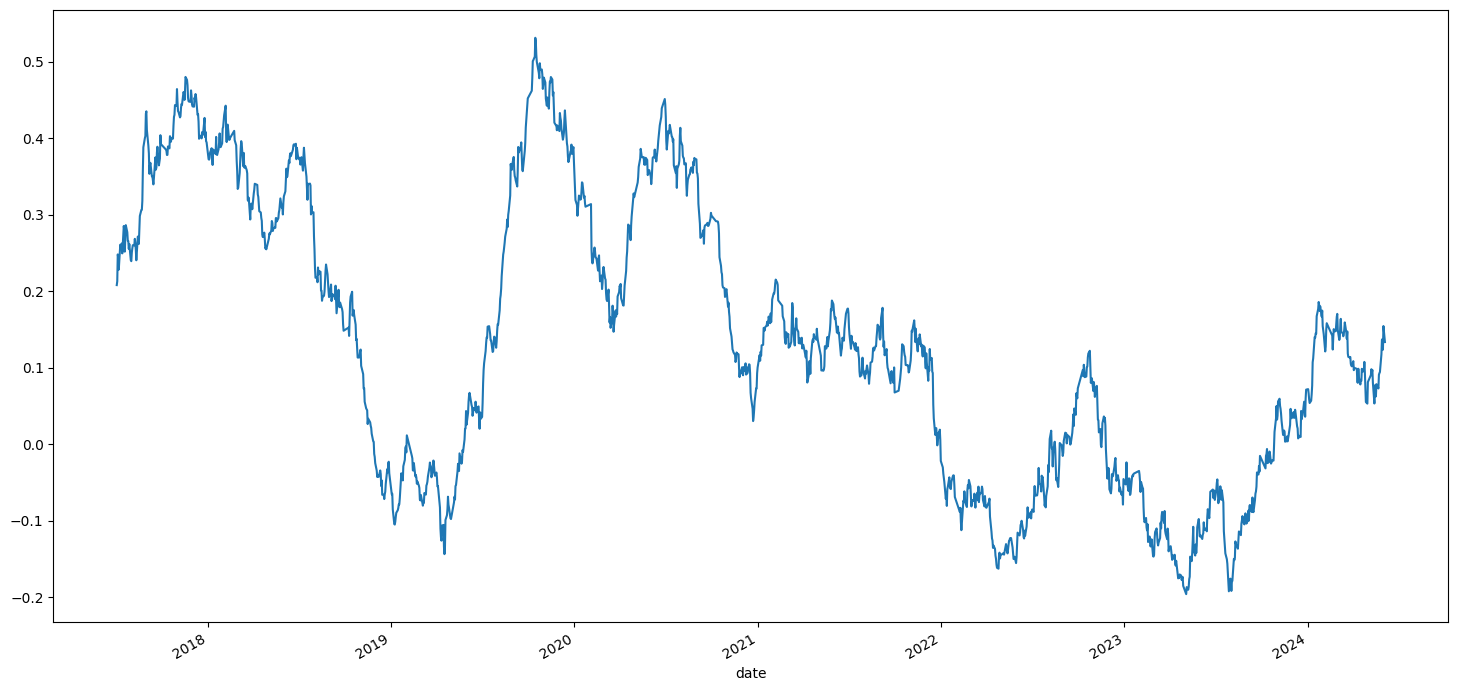

In [390]:
ICIR_120_weight = IC.rolling(120).apply(lambda x: x.mean()/x.std()).dropna()
ICIR_120_weight.plot(figsize=(18,9))
plt.show()

In [391]:
# ICIR_120_weight.to_pickle('D:/redata/icir/adjclose_icir.pkl')

<Axes: title={'center': 'rankIC0.0045 ICIR0.1154'}, xlabel='date'>

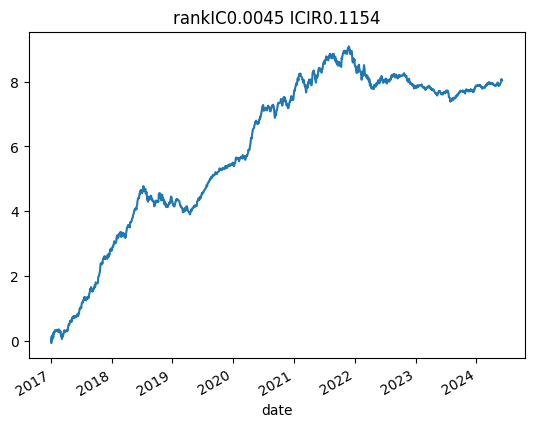

In [392]:
ic_title = 'rankIC'+str(round(ICres['ICmean'][0],4))+' ICIR'+str(round(ICres['ICIR'][0],4))
IC.cumsum().plot(title=ic_title)

abs(rankIC)>0.05 & ICIR>0.5 为优解

### 2.绝对收益,10层pnl

In [393]:
def compute_yield(weight_all):###通用的 输入weight计算pnl
    intra_return_open = ((Close / Open  - 1) * (adj_return.notnull() * 1.0).replace(0,np.nan)).replace(np.inf,np.nan).replace(-np.inf,np.nan)
    on_return_open = ((adj_return - intra_return_open) * (adj_return.notnull() * 1.0).replace(0,np.nan)).replace(np.inf,np.nan).replace(-np.inf,np.nan)

    turnover = (weight_all.replace(np.nan,0) - weight_all.replace(np.nan,0).shift(1)).dropna(how='all',axis=0).abs().sum(axis=1)
    n_shift = 1

    pnl_intra = ((weight_all).shift(n_shift) * intra_return_open).sum(axis=1)  
    pnl_on = ((weight_all).shift(n_shift + 1) * on_return_open).sum(axis=1)

    pnl = pnl_intra + pnl_on
    tcost =  turnover * 12 /(100*100)
    return pnl,tcost,turnover

def compute_abs_pnl(factor_rank):###计算分层收益
    dailyret = pd.DataFrame()
    dailyret_net = pd.DataFrame()
    turnover5 = []
    IC = []

    n_range = 10
    for layer in (range(n_range)):  # range(n_range):
        layer = layer + 1

        if layer == n_range:  # 最后一层，取值是取界限的闭区间
            weight1 = factor_rank.ge(factor_rank.max(axis=1) * (1 / n_range) * (layer - 1),axis=0)
        else:  # 前面几层都是左闭右开
            weight1 = (factor_rank.ge(factor_rank.max(axis=1) * (1 / n_range) * (layer - 1),axis=0)) & (factor_rank.lt(factor_rank.max(axis=1) * (1 / n_range) * (layer),axis=0))

        weight_all = (weight1.div(weight1.abs().sum(axis=1), axis=0)).replace(np.nan,0)  # 等权
        ####
       
        pnl,tcost,turnover = compute_yield(weight_all)
        
        dailyret['dailyret' + str(layer)] = pnl
        dailyret_net['dailyret' + str(layer)] = pnl - tcost
        turnover5.append(turnover.mean())

    # 去掉了因子值的第一天，少了最后一天
    start_date = factor_rank. index[1]
    end_date = factor_rank.index[-1] 
    dailyret = dailyret.loc[start_date:end_date]
    dailyret_net = dailyret_net.loc[start_date:end_date]
    return dailyret,dailyret_net,turnover5

In [394]:
dailyret,dailyret_net,turnover5 = compute_abs_pnl(factor_rank) 

### 3.根据universe算超额收益(相对csi500和股票池),超额收益pnl的评估结果，pic 分层收益图

In [395]:
def compute_factor_uni_ret():
    uni = ~np.isnan(factor_rank)
    weight_uni = uni.div(uni.sum(axis=1),axis=0)
    factor_uni_ret,_,_ = compute_yield(weight_uni)
    return factor_uni_ret

#年化收益
def evaluation(dailyret):
    # SHARP
    sharp = np.mean(dailyret) / np.std(dailyret) * np.sqrt(243)
    sharp = pd.DataFrame(sharp).T
    sharp.columns = [i.replace('dailyret', 'sharp') for i in sharp.columns]

    #年化收益
    yearly = dailyret.mean()*243
    yearly = pd.DataFrame(yearly).T
    yearly.columns = [i.replace('dailyret', 'yearly') for i in yearly.columns]
    
    # # TURNOVER
    turnover = pd.DataFrame(turnover5).T
    turnover.columns = ['turn' + str(i + 1) for i in turnover.columns]
    result = pd.concat([sharp, yearly,turnover], axis=1)
    return result.T
def excess_evaluation(excess_pnl,excess_net_pnl):
    res = evaluation(excess_pnl)
    res_net = evaluation(excess_net_pnl)
    res_all = pd.concat([res, res_net], axis=1)
    res_all.columns = ['res','res_net']
    return res_all
def pic(pnl,uni):
    plt.figure(figsize=(12, 7))
    plt.title(factor_name+uni, color='blue')
    plt.plot(pnl.index, pnl['dailyret1'].cumsum(), color='r', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret2'].cumsum(), color='y', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret3'].cumsum(), color='b', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret4'].cumsum(), color='g', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret5'].cumsum(), color='k', linestyle='-')
    plt.plot(pnl.index, pnl['dailyret6'].cumsum(), color='r', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret7'].cumsum(), color='y', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret8'].cumsum(), color='b', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret9'].cumsum(), color='g', linestyle='--')
    plt.plot(pnl.index, pnl['dailyret10'].cumsum(), color='k', linestyle='--')
    plt.grid()
    #plt.savefig(os.path.join(save_path,'pic',factor_name+uni+'.png'))
def output_res(res_all,layer):
    res_sharp = (res_all.head(layer)).reset_index(drop=True)
    res_sharp.columns = ['sharp','sharp_net']
    res_ret = (res_all.head(int(layer*2)).tail(layer)).reset_index(drop=True)
    res_ret.columns = ['return','return_net']
    res_turnover = (res_all.tail(layer)).reset_index(drop=True)
    res_turnover = res_turnover[['res']].rename(columns={'res':'turnover'})
    res_all = pd.concat([res_sharp,res_ret,res_turnover],axis=1)
    res_all = res_all.reset_index()
    res_all['index'] = res_all['index']+1
    res_all = res_all.set_index(['index'])
    res_all = res_all[['sharp', 'return', 'sharp_net', 'return_net', 'turnover']]
    return res_all

#### 相对csi500的超额收益

In [396]:
##相对csi500的超额收益
benchmark = 'csi500'
##compute
excess_pnl = dailyret.sub(idx_500_ret,axis=0)#.dropna(how='all',axis=0)
excess_net_pnl = dailyret_net.sub(idx_500_ret,axis=0)#.dropna(how='all',axis=0)
res_all = excess_evaluation(excess_pnl,excess_net_pnl)
output_res(res_all,layer = 10)

C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,sharp,return,sharp_net,return_net,turnover
index,,,,,
1,0.288862,-0.003637,-0.083233,-0.020080,0.056389
2,0.322559,0.004490,-0.092915,-0.028843,0.114313
3,0.333956,0.009364,-0.096203,-0.030059,0.135197
4,0.360318,0.027977,-0.103725,-0.016707,0.153238
5,0.385169,0.037436,-0.110882,-0.011417,0.167535
6,0.403403,0.027588,-0.116202,-0.023899,0.176566
7,0.418045,0.045388,-0.120364,-0.005602,0.174863
8,0.399870,0.064048,-0.115236,0.017240,0.160519
9,0.356958,0.053019,-0.102861,0.015539,0.128530


<Axes: title={'center': 'csi500_pnl'}, xlabel='date'>

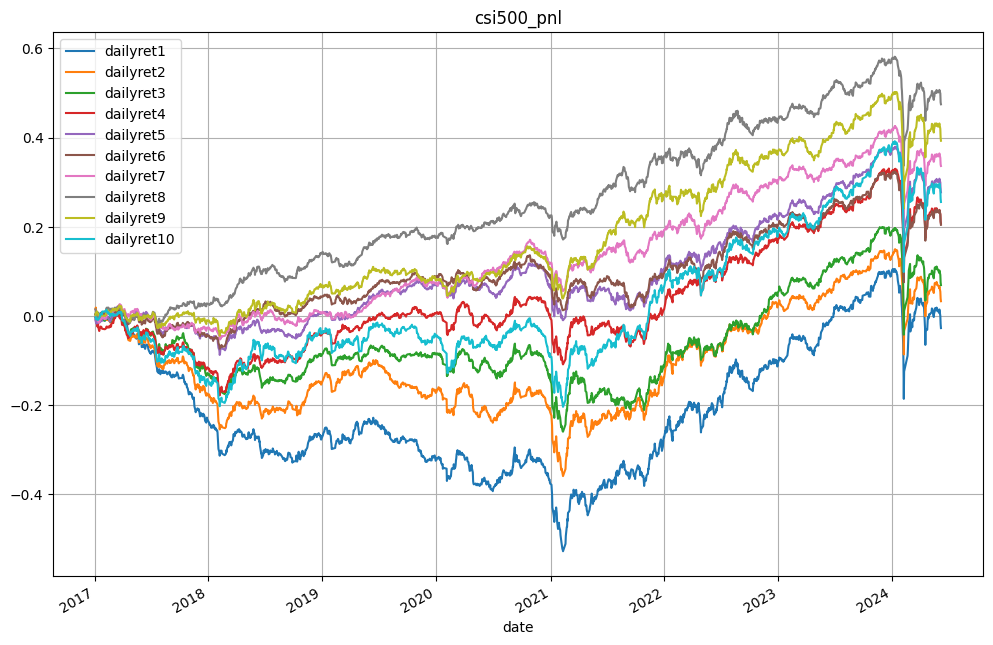

In [397]:
excess_pnl.loc[:].cumsum().plot(figsize=(12,8),grid=True,title='csi500_pnl')

#### 相对股票池组合的超额收益

In [398]:
benchmark = 'factor_uni'
factor_uni_ret = compute_factor_uni_ret() ###股票池的dailypnl 作为benchmark
##compute
excess_pnl = dailyret.sub(factor_uni_ret,axis=0)
excess_net_pnl = dailyret_net.sub(factor_uni_ret,axis=0)
res_all = excess_evaluation(excess_pnl,excess_net_pnl)

C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [399]:
output_res(res_all,layer = 10)

,sharp,return,sharp_net,return_net,turnover
index,,,,,
1,0.000095,-0.033651,-0.968152,-0.050094,0.056389
2,0.000108,-0.025523,-1.102446,-0.058857,0.114313
3,0.000129,-0.020649,-1.312502,-0.060073,0.135197
4,0.000149,-0.002036,-1.513058,-0.046721,0.153238
5,0.000148,0.007422,-1.503698,-0.041431,0.167535
6,0.000132,-0.002426,-1.353710,-0.053913,0.176566
7,0.000115,0.015374,-1.174476,-0.035616,0.174863
8,0.000109,0.034034,-1.119992,-0.012773,0.160519
9,0.000128,0.023005,-1.311488,-0.014475,0.128530


<Axes: title={'center': 'alluni_pnl'}, xlabel='date'>

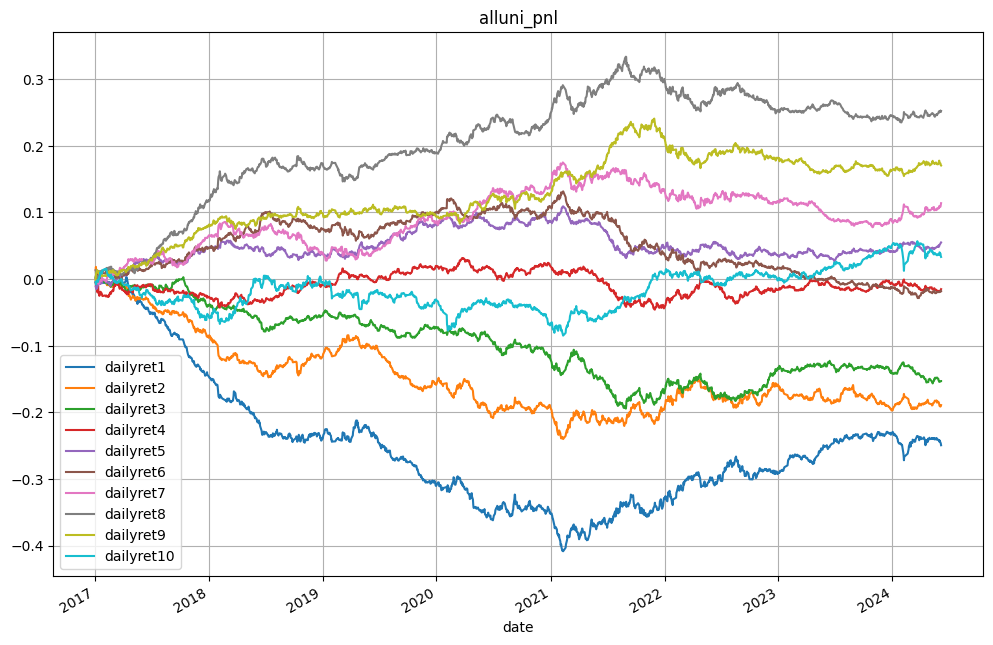

In [400]:
excess_pnl.loc[:].cumsum().plot(figsize=(12,8),grid=True,title='alluni_pnl')

### 4.单独看top10%组合，超额收益，以及每年表现

In [401]:
###top100， evalu
def comp_evaluation(pnl100_2):
    res = []
    year_ls = list(pd.DataFrame(pnl100_2.index)['date'].dt.year.unique())
    year_ls = [str(i) for i in year_ls]
    for year in year_ls:
        year_pnl100 = pnl100_2.loc[year]
        sharp = np.mean(year_pnl100) * np.sqrt(243) / np.std(year_pnl100)

        year_pnl100 = pnl100_2.loc[year]
        sumpnl = year_pnl100.sum()
        res.append(pd.DataFrame([[sharp.values[0],sumpnl.values[0]]],columns=['sharp', 'ret']))

    y = pd.concat(res)
    y.index = year_ls

    pnl100res_sum_sharp = pd.DataFrame((np.mean(pnl100_2) * np.sqrt(243)) / np.std(pnl100_2)).T
    pnl100res_sum_yearlymean = pd.DataFrame(pnl100_2.mean()*243).T


    y1 = pd.concat([pnl100res_sum_sharp,pnl100res_sum_yearlymean],axis=1)
    y1.columns = ['sharp', 'ret']
    y1.index = ['Yearly']

    y = pd.concat([y,y1])
    return y

In [402]:
def top10_comp(df):
    #top10%
    w = df.ge(df.max(axis=1) * args_quantile,axis=0) #top10
    #bottom 10%
    #w = df.le(df.max(axis=1) * args_quantile,axis=0)
    w100 =  (w.div(w.abs().sum(axis=1), axis=0)).replace(np.nan,0)#等权
    #w = (w*df).replace(0,np.nan).loc['2017-01-01':'2023-04-04']
    pnl,tcost,turnover100 = compute_yield(w100)
    pnl100 = pd.concat([pnl,pnl-tcost],axis=1).dropna()
    pnl100.columns = ['pnl','netpnl']
    #top100 超额dailypnl
    pnl100['excesspnl_csi500'] = pnl100['pnl'].sub(idx_500_ret,axis=0)
    pnl100['excessnetpnl_csi500'] = pnl100['netpnl'].sub(idx_500_ret,axis=0)
    pnl100['excesspnl_all'] = pnl100['pnl'].sub(factor_uni_ret,axis=0)
    pnl100['excessnetpnl_all'] = pnl100['netpnl'].sub(factor_uni_ret,axis=0)
    return pnl100,turnover100

In [403]:
args_quantile = 0.9

In [404]:
pnl100_hist,turnover = top10_comp(factor_rank.loc[:])

In [405]:
turnover.mean()

0.05900138119659207

In [406]:
##结果，相对csi500

In [407]:
#因子原值
pnl_tp = 'excesspnl_csi500'
pnl100_2 = pnl100_hist[[pnl_tp]]
y1 = comp_evaluation(pnl100_2)
#因子原值
pnl_tp = 'excessnetpnl_csi500'
pnl100_2 = pnl100_hist[[pnl_tp]]
y2 = comp_evaluation(pnl100_2)
y2.columns = ['sharp_net','ret_net']

C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [408]:
pd.concat([y1.T,y2.T])

,2017,2018,2019,2020,2021,2022,2023,2024,Yearly
sharp,-2.007037,1.198202,-0.059849,-0.581270,1.380896,1.199886,3.044622,-1.080478,0.329047
ret,-0.142139,0.102450,-0.003958,-0.046943,0.156149,0.117592,0.195494,-0.122935,0.034502
sharp_net,-2.484096,0.916631,-0.307069,-0.822387,1.226104,1.103175,2.966070,-1.095970,0.164908
ret_net,-0.176059,0.078440,-0.020324,-0.066382,0.138677,0.108065,0.190483,-0.124704,0.017297


<Axes: xlabel='date'>

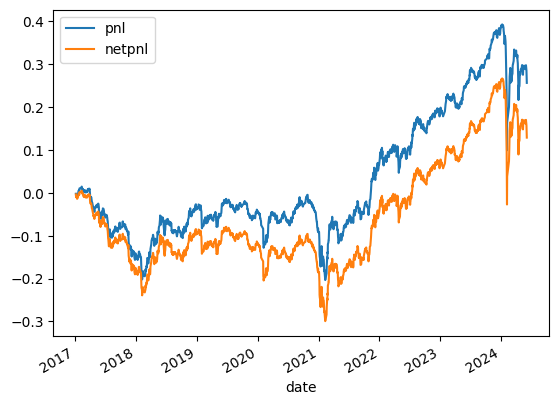

In [409]:
pd.concat([pnl100_hist['excesspnl_csi500'].loc[:].rename('pnl').cumsum(),pnl100_hist['excessnetpnl_csi500'].loc[:].rename('netpnl').cumsum()],axis=1).plot()

In [410]:
##结果，相对整个股票池

In [411]:
factor_uni_ret = compute_factor_uni_ret() ###股票池的dailypnl 作为benchmark

In [412]:
#因子原值
pnl_tp = 'excesspnl_all'
pnl100_2 = pnl100_hist[[pnl_tp]]
y1 = comp_evaluation(pnl100_2)
#因子原值
pnl_tp = 'excessnetpnl_all'
pnl100_2 = pnl100_hist[[pnl_tp]]
y2 = comp_evaluation(pnl100_2)
y2.columns = ['sharp_net','ret_net']

C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\sensen.t\Anaconda3\envs\nlp\lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [413]:
pd.concat([y1.T,y2.T])

,2017,2018,2019,2020,2021,2022,2023,2024,Yearly
sharp,-1.600416,1.143691,-0.721182,-1.092789,2.192902,-0.299553,2.121352,-0.853434,0.129049
ret,-0.053437,0.048245,-0.025325,-0.036711,0.074798,-0.009682,0.051378,-0.016003,0.004488
sharp_net,-2.603335,0.574227,-1.185276,-1.673232,1.679753,-0.593710,1.914438,-0.947687,-0.365085
ret_net,-0.087358,0.024235,-0.041692,-0.056150,0.057327,-0.019209,0.046367,-0.017771,-0.012717


<Axes: title={'center': 'alluni_top10%'}, xlabel='date'>

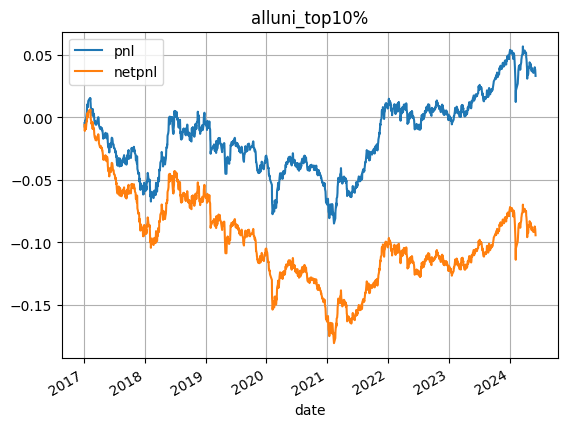

In [414]:
pd.concat([pnl100_hist['excesspnl_all'].loc[:].rename('pnl').cumsum(),pnl100_hist['excessnetpnl_all'].loc[:].rename('netpnl').cumsum()],axis=1).plot(grid=True,title='alluni_top10%')